# Links by the thesis of Lior

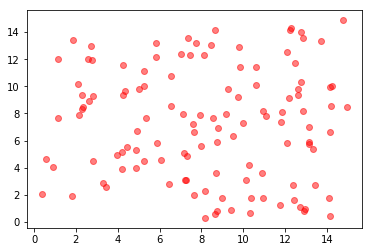

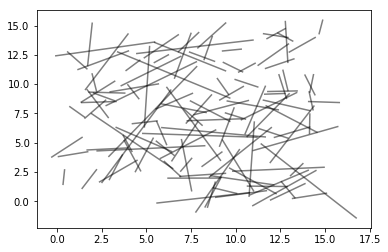

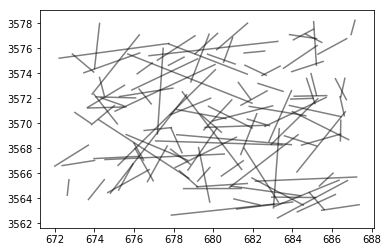

In [21]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

import sys
# the equivalent to "Add to path" in Matlab
sys.path.append("/Users/adameshel/Documents/Python_scripts/wrf_hydro_pyscripts/") 
sys.path.append("../my_fuctions/")
from geoFunc import *
from helper_functions import split_at
from os.path import isfile, join
import string
import random


%matplotlib inline

path = '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/'

domain_size = 15.0 # km
links_density = 0.53 # km**-2 multiply by 2 if you wish to do 50% link iter in rainsim
links_mean_length = 2.5 # km
num_of_links = int(np.ceil((domain_size ** 2) * links_density))
links_length_thresh = 4

links_cent = np.random.uniform(low=0.0, high=domain_size, size=[num_of_links,2]) +\
    np.random.normal(loc=0.0,scale=0.2, size=[num_of_links,2])
# links_lengths = np.squeeze(np.random.exponential(scale=links_mean_length,size=[num_of_links,1]))

# Truncate links' lengths
lower, upper, = 1, 10
X = stats.truncexpon(b=(upper-lower)/links_mean_length, loc=lower, scale=links_mean_length)
links_lengths = X.rvs(num_of_links)

fig, ax = plt.subplots()#figsize=(15,10)
ax.plot(links_cent[:,0],links_cent[:,1], 'ro', alpha = 0.5)

#rotation matrix
theta = np.radians(np.random.uniform(low=0.0, high=179.9999, size=[num_of_links,1]))

theta = np.squeeze(theta)
links_xa = (-links_lengths/2)*np.cos(theta) + links_cent[:,0] #+ 672.2919656637181
links_ya = (-links_lengths/2)*np.sin(theta) + links_cent[:,1] #+ 3562.7985050678294
links_xb = (links_lengths/2)*np.cos(theta) + links_cent[:,0] #+ 672.2919656637181
links_yb = (links_lengths/2)*np.sin(theta) + links_cent[:,1] #+ 3562.7985050678294
    

fig, ax = plt.subplots()#figsize=(15,10)
line = ax.plot([links_xa,links_xb],
                [links_ya,links_yb],
                'k', alpha=0.5)


def link_id_gen(num_of_ids=1, size=8, chars=string.ascii_uppercase + string.digits):
    my_id_list = list()
    for i in range(num_of_links):
        my_id = ''.join(random.choice(chars) for _ in range(size))
        my_id_list.append(my_id[:4] + '-' + my_id[4:])
    return my_id_list

df_sim_input = pd.DataFrame(columns= ['SP','Link_num','Freq_1','Polar_1','Freq_2','Polar_2','xa','ya','xb','yb'])
df_sim_input['Link_num'] = link_id_gen(num_of_ids=num_of_links)
df_sim_input['SP'] = 'cellcom'
# df_sim_input['Freq_1'] = np.random.choice([8, 18, 23, 38], df_sim_input.shape[0])
df_sim_input['Polar_1'] = np.random.choice(['H', 'V', 'V'], df_sim_input.shape[0])
df_sim_input['Freq_2'] = 19
df_sim_input['Polar_2'] = 'V'
df_sim_input['xa'] = links_xa
df_sim_input['ya'] = links_ya
df_sim_input['xb'] = links_xb
df_sim_input['yb'] = links_yb

df_sim_input = df_sim_input[df_sim_input.xa > links_cent[:,0].min() - (domain_size * 0.05)]
df_sim_input = df_sim_input[df_sim_input.xb > links_cent[:,0].min() - (domain_size * 0.05)]
df_sim_input = df_sim_input[df_sim_input.xa < links_cent[:,0].max() + (domain_size * 0.05)]
df_sim_input = df_sim_input[df_sim_input.xb < links_cent[:,0].max() + (domain_size * 0.05)]

df_sim_input = df_sim_input[df_sim_input.ya > links_cent[:,1].min() - (domain_size * 0.05)]
df_sim_input = df_sim_input[df_sim_input.yb > links_cent[:,1].min() - (domain_size * 0.05)]
df_sim_input = df_sim_input[df_sim_input.ya < links_cent[:,1].max() + (domain_size * 0.05)]
df_sim_input = df_sim_input[df_sim_input.yb < links_cent[:,1].max() + (domain_size * 0.05)]

df_sim_input = df_sim_input.reset_index(drop=True)

df_sim_input['xa'] = df_sim_input['xa'] + 672.2919656637181 # coords of Emek Hefer
df_sim_input['ya'] = df_sim_input['ya'] + 3562.7985050678294 # coords of Emek Hefer
df_sim_input['xb'] = df_sim_input['xb'] + 672.2919656637181
df_sim_input['yb'] = df_sim_input['yb'] + 3562.7985050678294

fig, ax = plt.subplots()#figsize=(15,10)
line = ax.plot([df_sim_input['xa'],df_sim_input['xb']],
                [df_sim_input['ya'],df_sim_input['yb']],
                'k', alpha=0.5)

df_sim_input['Length_aprx'] = np.sqrt((df_sim_input['xb'].values-df_sim_input['xa'].values)**2 + \
                                      (df_sim_input['yb'].values-df_sim_input['ya'].values)**2)

# Setting the frequencies by looking at real links' length-frek distribution
rnd_size_temp = len(df_sim_input.loc[df_sim_input.Length_aprx > links_length_thresh])
frek_rand_dist_for_long = np.random.normal(loc=0.0,
                                           scale=0.5, 
                                           size=rnd_size_temp)

# For long links
for i, idx in enumerate(df_sim_input[df_sim_input['Length_aprx'] > links_length_thresh].index):
    df_sim_input.loc[idx,'Freq_1'] = \
    17.3 + frek_rand_dist_for_long[i]

rnd_size_temp = len(df_sim_input.loc[df_sim_input.Length_aprx <= links_length_thresh])
frek_rand_dist_for_short = np.random.choice([17, 22, 38],size=rnd_size_temp) + \
    np.random.normal(loc=0.0,
                     scale=0.5,
                     size=rnd_size_temp)
# For short links
for i, idx in enumerate(df_sim_input[df_sim_input['Length_aprx'] <= links_length_thresh].index):
    df_sim_input.loc[idx,'Freq_1'] = \
    frek_rand_dist_for_short[i]
    
df_sim_input['xa'], df_sim_input['ya'] = utm2geo(E=df_sim_input['xa'].values, 
                                                 N=df_sim_input['ya'].values, 
                                                 lon0=33)
df_sim_input['xb'], df_sim_input['yb'] = utm2geo(E=df_sim_input['xb'].values, 
                                                 N=df_sim_input['yb'].values, 
                                                 lon0=33)
df_sim_input.drop(columns=['Length_aprx'], inplace=True)


In [22]:
now = datetime.datetime.now()

df_sim_input.to_csv(path + 'synthetic_links_for_RainSim_' + str(now)[0:4] + '_' + str(now)[5:7] \
                    + '_' + str(now)[8:10] + '.csv', index=False)

df_sim_input.head()

,SP,Link_num,Freq_1,Polar_1,Freq_2,Polar_2,xa,ya,xb,yb
0,cellcom,C8NU-A88H,38.2557,H,19,V,34.966680,32.206181,34.974194,32.215290
1,cellcom,Q4HF-N00P,16.961,H,19,V,34.902186,32.302613,34.914487,32.317106
2,cellcom,CWYY-F7TG,17.0364,V,19,V,34.967435,32.312505,34.953040,32.315642
3,cellcom,VUEP-JN11,16.6892,V,19,V,34.967997,32.301282,34.983603,32.312240
4,cellcom,VKUS-72TL,22.2843,V,19,V,34.899428,32.282290,34.909913,32.316558


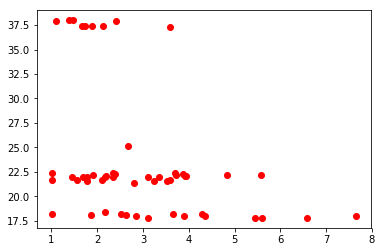

In [3]:
links_ex_path = '/Volumes/0543970348/IE_directory/22022016_24h_data/singleDirection/topLeft_for_RainSim_2018_10_21.csv'
links_ex = pd.read_csv(links_ex_path)
links_ex['L'] = links_ex.apply(lambda r: haversine(r['xa'], r['ya'], r['xb'], r['yb']), axis=1)
# links_ex
plt.plot(links_ex.L, links_ex.Freq_1, 'or')
# plt.hist(links_ex.Freq_1)